<a href="https://colab.research.google.com/github/syousefpourziaei-byte/Computational-Biology/blob/main/STMdefect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Detected 794 candidate defect regions.
Image size: 804 x 808 pixels (area = 649632 pixels^2)
Defect density (per pixel)       : 1.222230e-03 defects/pixel
Defect density (per 10,000 px^2) : 12.222 defects / 1e4 pixels
Assuming scan area = 40.0 x 40.0 nm^2 (1600.0 nm^2)
Defect density (physical)        : 4.963e-01 defects / nm^2


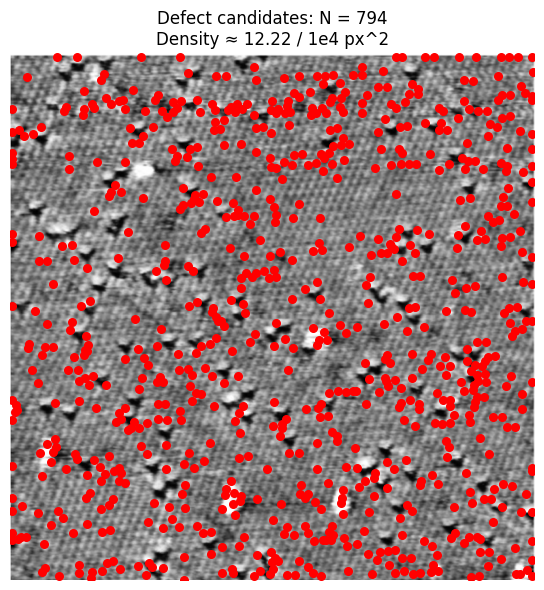

Saved overlay image to: /content/mos2_stm_defects_overlay.png


In [1]:
# =======================
# STM MoS2 Image Processing
# - Defect detection
# - Colored defect points
# - Defect density calculation
# =======================

# Install dependency (run once per runtime)
%pip install -q scikit-image

import numpy as np
import matplotlib.pyplot as plt

from skimage import io, filters, exposure, morphology, measure, color

# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
IMAGE_PATH = "/content/STM image1.png"   # e.g., "/content/your_image.png"

# For example: a 20 nm x 20 nm STM scan → SCAN_SIZE_NM = 20
SCAN_SIZE_NM = 40.0   # e.g., 20.0
# <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

# 1) Load image safely (handles RGBA, RGB, grayscale)
img = io.imread(IMAGE_PATH)
img = img.astype(np.float32)

# Remove alpha channel if present (RGBA → RGB)
if img.ndim == 3 and img.shape[-1] == 4:
    img = img[:, :, :3]

# Convert to grayscale
if img.ndim == 3:
    img_gray = color.rgb2gray(img)
else:
    img_gray = img

# Normalize to [0, 1]
img_gray = (img_gray - img_gray.min()) / (img_gray.max() - img_gray.min() + 1e-8)

# 2) Remove large-scale background (flatten drift)
background = filters.gaussian(img_gray, sigma=5.0)
img_flat = img_gray - background
img_flat = (img_flat - img_flat.min()) / (img_flat.max() - img_flat.min() + 1e-8)

# 3) Enhance local contrast
img_eq = exposure.equalize_adapthist(img_flat, clip_limit=0.03)

# 4) Detect "defect-like" spots (simple Laplacian-based method)
smoothed = filters.gaussian(img_eq, sigma=1.0)
log_response = -filters.laplace(smoothed)

# Threshold: mean + k * std (you can tweak k if needed)
k = 1.5
thresh = log_response.mean() + k * log_response.std()
spots = log_response > thresh

# 5) Clean mask and remove tiny noise
spots = morphology.remove_small_objects(spots, min_size=5)
spots = morphology.binary_opening(spots, morphology.disk(1))

# 6) Label regions and extract properties
labels = measure.label(spots)
regions = measure.regionprops(labels)

num_defects = len(regions)
print(f"Detected {num_defects} candidate defect regions.")

# 7) Build coordinates of defect centers (for colored points)
ys = []
xs = []
for r in regions:
    cy, cx = r.centroid
    ys.append(cy)
    xs.append(cx)

# 8) Compute defect density (in pixel space)
h, w = img_gray.shape
area_pixels = h * w

density_per_pixel = num_defects / area_pixels if area_pixels > 0 else 0.0
density_per_1e4_pixels = density_per_pixel * 1e4  # convenient scaled number

print(f"Image size: {w} x {h} pixels (area = {area_pixels} pixels^2)")
print(f"Defect density (per pixel)       : {density_per_pixel:.6e} defects/pixel")
print(f"Defect density (per 10,000 px^2) : {density_per_1e4_pixels:.3f} defects / 1e4 pixels")

# 9) physical defect density
if SCAN_SIZE_NM is not None:
    # Assume square scan: SCAN_SIZE_NM x SCAN_SIZE_NM
    scan_area_nm2 = (SCAN_SIZE_NM ** 2)
    density_per_nm2 = num_defects / scan_area_nm2 if scan_area_nm2 > 0 else 0.0
    print(f"Assuming scan area = {SCAN_SIZE_NM} x {SCAN_SIZE_NM} nm^2 "
          f"({scan_area_nm2:.1f} nm^2)")
    print(f"Defect density (physical)        : {density_per_nm2:.3e} defects / nm^2")

# 10) Plot result: original + colored defect points overlay
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(img_gray, cmap="gray")
ax.scatter(xs, ys, s=30, c="red", marker="o")  # colored defect points
title_txt = f"Defect candidates: N = {num_defects}"
if SCAN_SIZE_NM is not None:
    title_txt += f"\nDensity ≈ {density_per_1e4_pixels:.2f} / 1e4 px^2"
ax.set_title(title_txt)
ax.axis("off")

plt.tight_layout()
plt.show()

# 11) Save overlay image to file
output_path = "/content/mos2_stm_defects_overlay.png"
fig.savefig(output_path, dpi=300, bbox_inches="tight")
print(f"Saved overlay image to: {output_path}")
